In [26]:
# Import necessary libraries and packages
import pandas as pd
import numpy as np
from matplotlib import pyplot
import warnings
import matplotlib.pyplot as plt
from math import exp
from numpy import log
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Preferred settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)


In [2]:
#Import CO2 emissions data - OWID
data = pd.read_csv('../Data/carbon-emissions/owid-co2-data.csv')

#Observe data shape and head
print(data.shape)

(25204, 58)


In [3]:
data.describe()

,year,co2,consumption_co2,co2_growth_prct,co2_growth_abs,trade_co2,co2_per_capita,consumption_co2_per_capita,share_global_co2,cumulative_co2,share_global_cumulative_co2,co2_per_gdp,consumption_co2_per_gdp,co2_per_unit_energy,coal_co2,cement_co2,flaring_co2,gas_co2,oil_co2,other_industry_co2,cement_co2_per_capita,coal_co2_per_capita,flaring_co2_per_capita,gas_co2_per_capita,oil_co2_per_capita,other_co2_per_capita,trade_co2_share,share_global_cement_co2,share_global_coal_co2,share_global_flaring_co2,share_global_gas_co2,share_global_oil_co2,share_global_other_co2,cumulative_cement_co2,cumulative_coal_co2,cumulative_flaring_co2,cumulative_gas_co2,cumulative_oil_co2,cumulative_other_co2,share_global_cumulative_cement_co2,share_global_cumulative_coal_co2,share_global_cumulative_flaring_co2,share_global_cumulative_gas_co2,share_global_cumulative_oil_co2,share_global_cumulative_other_co2,total_ghg,ghg_per_capita,methane,methane_per_capita,nitrous_oxide,nitrous_oxide_per_capita,population,gdp,primary_energy_consumption,energy_per_capita,energy_per_gdp
count,25204.000000,23949.000000,3976.000000,24931.000000,23585.000000,3976.000000,23307.000000,3976.000000,23949.000000,2.394900e+04,23949.000000,15389.000000,3761.000000,9141.000000,17188.000000,12248.000000,4382.000000,8845.000000,20539.000000,1999.000000,12218.000000,16860.000000,4381.000000,8835.000000,20181.000000,1999.000000,3976.000000,12248.000000,17188.00000,4382.000000,8845.000000,20539.000000,1999.000000,12248.000000,17188.000000,4382.000000,8845.000000,20539.000000,1999.000000,12248.000000,17188.000000,4382.000000,8845.000000,20539.000000,1999.000000,5208.000000,5155.000000,5211.000000,5157.000000,5211.000000,5157.000000,2.287800e+04,1.353800e+04,8690.000000,8681.000000,6803.000000
mean,1953.225797,267.861942,916.755170,21.098600,5.146889,-2.415624,4.170811,6.567721,4.983979,1.035710e+04,5.126531,0.421795,0.370038,0.238931,175.358171,12.888607,15.000326,108.750774,106.254381,15.753891,0.113037,1.551520,0.875319,1.413336,2.635498,0.080168,22.961190,4.419452,6.98983,5.861506,5.405564,2.993497,14.295183,307.761167,8791.767180,425.698588,2587.096729,3296.584230,293.588436,4.462228,7.211834,5.621670,5.242400,3.001620,13.403622,441.481429,8.099506,82.253370,2.046923,29.308135,0.606690,7.072322e+07,2.877088e+11,1569.083895,25568.487454,1.850291
std,53.791369,1521.680894,3373.348275,702.565991,55.259760,182.444942,14.912201,6.927957,17.704994,6.120603e+04,18.480079,0.483864,0.265374,0.233550,786.106838,77.258563,40.471977,441.064563,602.683622,39.385589,0.148907,2.552112,5.477923,3.654290,15.129275,0.055779,45.055039,15.950613,20.76197,14.874259,18.408881,12.018682,28.570911,1706.159528,39131.720328,1320.911296,12347.690600,21645.263301,777.706862,15.685264,21.636504,15.021334,18.926934,12.134102,27.019447,3089.039496,9.387477,566.702756,3.534126,199.291118,0.844671,3.795858e+08,2.180094e+12,9066.102799,33319.956208,1.575161
min,1750.000000,0.000000,0.197000,-99.640000,-1895.244000,-1657.998000,0.000000,0.055000,0.000000,0.000000e+00,0.000000,0.000000,0.006000,0.005000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-96.760000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-85.620000,-50.487000,0.000000,0.000000,0.000000,0.000000,1.490000e+03,5.543200e+07,0.000000,0.000000,0.050000
25%,1925.000000,0.528000,10.319750,-0.450000,-0.011000,-0.892500,0.253000,1.240250,0.010000,6.992000e+00,0.000000,0.140000,0.216000,0.178000,0.322000,0.129000,0.253250,0.385000,0.311000,0.747500,0.020000,0.054000,0.021000,0.031000,0.121000,0.036000,-1.757500,0.050000,0.01000,0.090000,0.030000,0.010000,0.300000,1.613000,5.516250,4.071250,3.239000,3.921000,7.709000,0.040000,0.000000,0.060000,0.010000,0.010000,0.190000,8.162500,2.514000,2.150000,0.715000,0.535000,0.228000,1.291899e+06,9.828867e+09,6.997000,3270.369000,0.856000
50%,1967.00

# Data Cleaning and Preprocessing

We focused on post-1950 data for our comparative analysis and global EDA since some countries are missing significant data before that time. Major carbon emitting countries' emission activites intensified post 1950 period, especially India. For our modelling process, however, focusing on India, the data form 1878 is continous, so we include all data for India from 1900. First, We'll be predicting the CO2 emissions for India

In [4]:
#load data
df_India = data

#only include India co2 per capita data post-1900
df_India = df_India[df_India['year'] >= 1900]
df_India = df_India[df_India['country'] == 'India']
df_India = df_India[['year', 'co2_per_capita']]

#observe shape of reformatted df
print(df_India.shape)

(121, 2)


In [5]:
#Convert year to index
df_India.set_index('year', inplace=True)

#Convert year to DateTime object
df_India.index = pd.to_datetime(df_India.index, format='%Y')

In [6]:
#observe updated df
#df_India.head()
df_India.sample(5)

,co2_per_capita
year,
1996-01-01,0.841
1966-01-01,0.313
1912-01-01,0.092
2007-01-01,1.148
1968-01-01,0.328


# Exploratory Data Analysis

Before starting to analyse the stationarity of data, lets need to understand the trend, seasonality and bias of our data. 

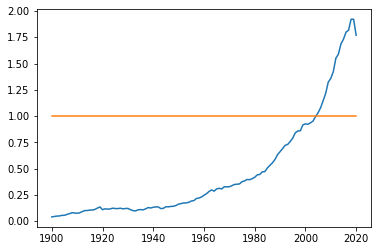

In [7]:
#observe trend and seasonality
decom = seasonal_decompose(df_India['co2_per_capita'], model='multiplicative')
plt.plot(decom.trend)
plt.plot(decom.seasonal)


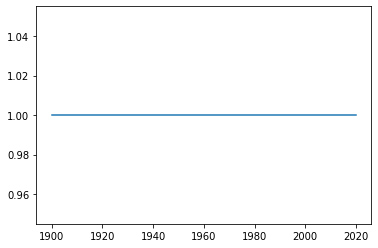

In [8]:
#observe residue
plt.plot(decom.resid)

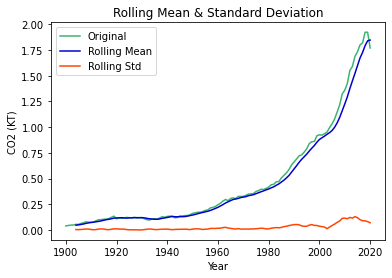

In [9]:
#Visualize India's CO2 emissions since 1900,
#including 5-year rolling mean and rolling standard deviation

roll_mean = df_India.rolling(window=5, center=False).mean()
roll_std = df_India.rolling(window=5, center=False).std()

plt.plot(df_India, color='mediumseagreen', label='Original')
plt.plot(roll_mean, color='mediumblue', label='Rolling Mean')
plt.plot(roll_std, color='orangered', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.xlabel('Year')
plt.ylabel('CO2 (KT)')
plt.show(block=False)

Working with time series data we need to understand the nature of data, that is the trends and stationarity.

Stationarity can be checked by performing an **Augmented Dickey-Fuller (ADF) test** 

null hypothesis - there is a unit root in an AR model, which implies that the data series is not stationary

> - p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
> - p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary

#### Dickey-Fuller Test

In [10]:
#perform Dickey-Fuller test
test_result = adfuller(df_India['co2_per_capita'][1:-1])
df_result = pd.Series(test_result[0:5], index=['ADF Statistic','p-value','#Lags Used','No. of Observations Used', 'Critical Values'])
df_result

ADF Statistic                                                        4.772611
p-value                                                                   1.0
#Lags Used                                                                 12
No. of Observations Used                                                  106
Critical Values             {'1%': -3.4936021509366793, '5%': -2.889217423...
dtype: object

With p-value of 1.0 ( >0.05), we cannot reject that null hypothesis that this is non-stationary.

we also can see that our ADF statistic value (6.76) is greater than tha value -3.49 at 1%. This suggests that we cannot reject the null hypothesis with a significance of less than 1%, i.e. a low probability that the result is a statistical fluke. The process has unit root and in turn the timer series is un-stationary or does have time-dependent structure

As we observe the data is non-stationary, this cannot be fit for autocorrelation analysis as ACF and PACF assumes data stationary. Lets remedy this below before fitting our model.
    

## Addressing Trends and Stationarity

### Log Transformation

In log transformation we apply logarithmic function to a point, and model the time series with the new log-transformed data. 

we can address lack of variance and covariance by log transformation

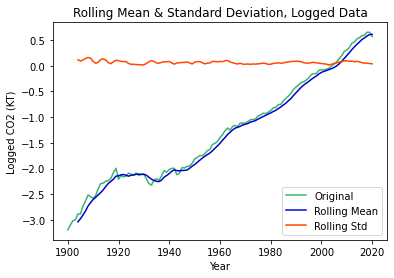

In [11]:
#apply log transformation
#Create new dataframe that contains the logged values of the original one
log_India = log(df_India)

#Visualize Logged data, including 5-year rolling mean and standard deviation
roll_mean_log = log_India.rolling(window=5, center=False).mean()
roll_std_log = log_India.rolling(window=5, center=False).std()

plt.plot(log_India, color='mediumseagreen', label='Original')
plt.plot(roll_mean_log, color='mediumblue', label='Rolling Mean')
plt.plot(roll_std_log, color='orangered', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation, Logged Data')
plt.xlabel('Year')
plt.ylabel('Logged CO2 (KT)')
plt.show(block=False)

Lets again check the p-value by doing a ADF test

**Dickey-Fuller test for log transformed data**

In [12]:
#perform Dickey-Fuller test for log tranformed data
test_result = adfuller(log_India['co2_per_capita'][1:-1])
df_log_result = pd.Series(test_result[0:5], index=['ADF Statistic','p-value','#Lags Used','No. of Observations Used', 'Critical Values'])
df_log_result

ADF Statistic                                                        1.182281
p-value                                                              0.995861
#Lags Used                                                                 11
No. of Observations Used                                                  107
Critical Values             {'1%': -3.492995948509562, '5%': -2.8889546480...
dtype: object

With p-value of 0.99 ( >0.05), we still cannot reject that null hypothesis that this data is non-stationary. 

Log transformation did not help achieve stationarity. So lets try another way to achieve true stationarity by subtracting rolling mean of log tranformation



#### Subtracting the Rolling Mean of the Log Transformation

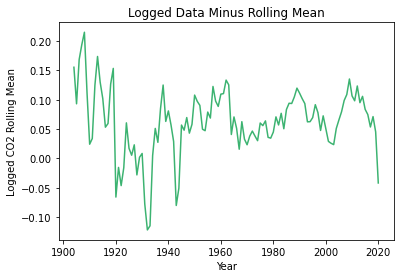

In [13]:
#subtracting rolling mean of log transformation
log_minus_rollmean = log_India - roll_mean_log

#drop null values
log_minus_rollmean.dropna(axis=0, inplace=True)

#observe data
plt.plot(log_minus_rollmean, color='mediumseagreen')
plt.title('Logged Data Minus Rolling Mean')
plt.xlabel('Year')
plt.ylabel('Logged CO2 Rolling Mean')
plt.show(block=False)


Lets again check the p-value by doing a ADF test

**Dickey-Fuller test for log-minus-roll-mean data**

In [14]:
#perform Dickey-Fuller test for log-minus-rollmean data
test_result = adfuller(log_minus_rollmean['co2_per_capita'][1:-1])
df_sublog_result = pd.Series(test_result[0:5], index=['ADF Statistic','p-value','#Lags Used','No. of Observations Used', 'Critical Values'])
df_sublog_result

ADF Statistic                                                       -3.855635
p-value                                                              0.002387
#Lags Used                                                                 13
No. of Observations Used                                                  101
Critical Values             {'1%': -3.4968181663902103, '5%': -2.890610751...
dtype: object

With p-value of 0.002 ( <0.05), we reject that null hypothesis. This data does not unit root and is stationary.

we also can see that our ADF statistic value (-3.85) is less than the value -3.49 at 1%. This suggests that we can reject the null hypothesis with a significance of less than 1%.

This data looks much more stationary based on its plot and its Dickey-Fuller test alos yielded similar observation as observed above with a very low p-value, indicating that we can confidently reject the null hypothesis that the data is non-stationary.



> Even though this data is stationary and would likely work well in a time series model, the results of this model would not be interpretable in the context of our business problem.  

> For our predictions to be useful, we need them to be in terms of CO2 emissions in K Tonnes. Altering our data to this degree would make them uninterpretable for this purpose, and so we will not pursue a model on this data

### Differencing

differencing is a very powerful technique to address non-stationary time-series data. Differencing works very well with practical time series.

The original data where the ADF test arrived at p-value = 1 suggests no difference between the groupds other than due to chance


Now that we have observed log tranformed, we will now observe differnece of our original data until we achieve stationarity so we can model on both datasets

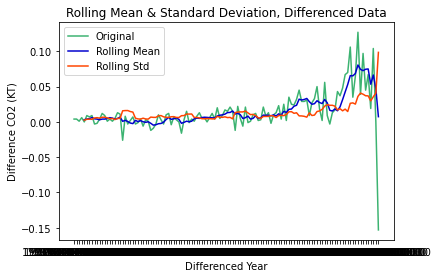

In [15]:
#create dataframe for differencing
diff = df_India.diff().dropna().rename(index=str, columns={"co2_per_capita":"Differenced Observations"})

#Visualize differenced data, inclusing 5-year rolling mean and standard deviation
roll_mean_diff = diff.rolling(window=5, center=False).mean()
roll_std_diff = diff.rolling(window=5, center=False).std()

plt.plot(diff, color='mediumseagreen', label='Original')
plt.plot(roll_mean_diff, color='mediumblue', label='Rolling Mean')
plt.plot(roll_std_diff, color='orangered', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation, Differenced Data')
plt.xlabel('Differenced Year')
plt.ylabel('Difference CO2 (KT)')
plt.show(block=False)


Lets again check the p-value by doing a ADF test

**Dickey-Fuller test for log-minus-roll-mean data**

In [16]:
#perform Dickey-Fuller test for log-minus-rollmean data
diff_result = adfuller(diff['Differenced Observations'][1:-1])
df_diff_result = pd.Series(diff_result[0:5], index=['ADF Statistic','p-value','#Lags Used','No. of Observations Used', 'Critical Values'])
df_diff_result

ADF Statistic                                                        -1.11171
p-value                                                               0.71038
#Lags Used                                                                  3
No. of Observations Used                                                  114
Critical Values             {'1%': -3.489057523907491, '5%': -2.8872463271...
dtype: object

Applying 1st order differencing to the original data (p-value = 1), we observe p-value obtained performing ADF test on differenced data is 0.714 (>0.05). we cannot reject the null hypothesis.

we also can see that our ADF statistic value (-1.10) is greater than the value -3.48 at 1%. This suggests that we cannot reject the null hypothesis with a significance of less than 1%.

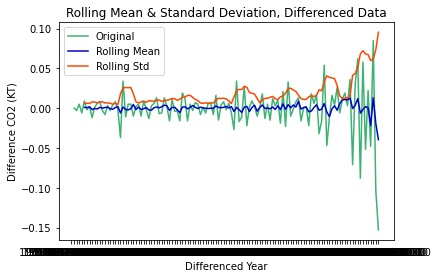

In [17]:
diff2 = diff.diff().rename(index=str, columns={"Differenced Observations":"2nd"})

#Visualize differenced data, inclusing 5-year rolling mean and standard deviation
roll_mean_diff = diff2.rolling(window=5, center=False).mean()
roll_std_diff = diff2.rolling(window=5, center=False).std()

plt.plot(diff2, color='mediumseagreen', label='Original')
plt.plot(roll_mean_diff, color='mediumblue', label='Rolling Mean')
plt.plot(roll_std_diff, color='orangered', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation, Differenced Data')
plt.xlabel('Differenced Year')
plt.ylabel('Difference CO2 (KT)')
plt.show(block=False)


In [18]:
#perform Dickey-Fuller test for log-minus-rollmean data
diff2_result = adfuller(diff2['2nd'][1:-1])
df_diff2_result = pd.Series(diff2_result[0:5], index=['ADF Statistic','p-value','#Lags Used','No. of Observations Used', 'Critical Values'])
df_diff2_result

ADF Statistic                                                      -10.832628
p-value                                                                   0.0
#Lags Used                                                                  2
No. of Observations Used                                                  115
Critical Values             {'1%': -3.4885349695076844, '5%': -2.887019521...
dtype: object

Statistically p-value can never be absolute zero as it means event we are already observing doesn't exist.

While addressing stationarity of time series data, this observation can reject the null hypothesis (real p-value observed is in the order of 1.69e-19). 
The ADF statistic value (-10.80) is very much less than the value -3.48 at 1%. This suggests that we can comfortably reject the null hypothesis with a significance of less than 1%.

Based on real p-value of 1.69e-19, twnding to zero, we have achieved stationarity by 2nd order differencing. We will keep this in count as we test d values in our ARIMA models


## Modelling


We will create time series models on both our logged data and original data to see which yields better results.

### Logged Data

**ACF for Logged Data**

ACF gives correlation between time series with a lagged version of itself. The autocorrelation function starts a lag 0, which is correlation of the time series with itself and therefore results in correlation of 1.

Auto correlation graphs are used to determine the order of MA model (p values) to be used in the ARIMA Model

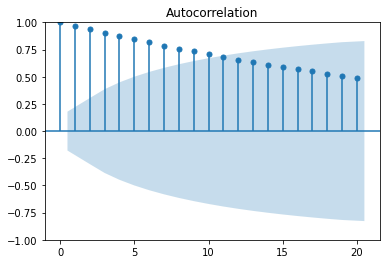

In [119]:
# observe ACF for logged data
plot_acf(log_India[:-1], alpha=.05, lags=20);

**PACF for Logged Data**

PACF gives additional correaltion explained by each successive lagged term. A partial autocorrelation at lag k is the autocorrelation between 𝑋𝑡  and 𝑋𝑡−𝑘. 

Partial Autocorrelation are used to determine the order of AR model - q values to be used in the ARIMA Model

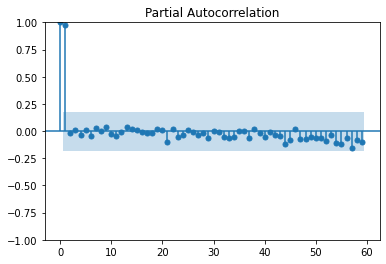

In [59]:
# PACF for logged data
plot_pacf(log_India[:-1], alpha=.05, lags=59);

From the above ACF and PACF for our logged data, we can observe

> - A series that has a dampened geometric decay of Autocorrelation and Significant at each lag  𝑝  / Cuts off after lag  𝑝 - AR  𝑝   model

> -  Our data displayes an AR signature since ACF diminishes gradually and the PACF uctts off sharply at lag 2, showing string correlation. This tells us we would expect to have atleast one AR parameter.

> -  When instantiating an ARIMA model, we expect a relatively large number of MA terms due to large number of significant ACF points and relatively smaller AR terms due to small number of significant PACF points.

**ARIMA Model for Logged Data**

In [128]:
#instantiate ARIMA model for logged data

#Instantiate model
model_log = ARIMA(log_India[:-1], order=(2,0,0))

#Fit Model
results = model_log.fit()

#observe summary statistics
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:         co2_per_capita   No. Observations:                  120
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 169.946
Date:                Tue, 22 Mar 2022   AIC                           -331.891
Time:                        23:25:53   BIC                           -320.741
Sample:                    01-01-1900   HQIC                          -327.363
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.3091    444.093     -0.003      0.998    -871.716     869.098
ar.L1          1.3204      0.081     16.350      0.000       1.162       1.479
ar.L2         -0.3204      0.081     -3.968      0.0

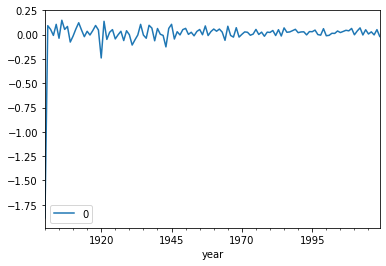

In [129]:
from pandas import DataFrame
residuals = DataFrame(results.resid)
residuals.plot()
plt.show()


In [125]:
residuals.describe()

,0
count,120.000000
mean,0.006081
std,0.181660
min,-1.885122
25%,-0.004703
50%,0.026785
75%,0.052546
max,0.149017


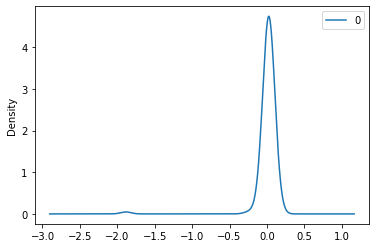

In [126]:
residuals.plot(kind='kde')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

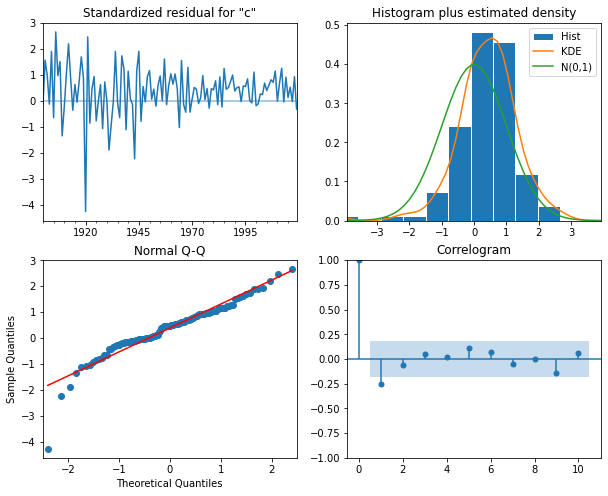

In [130]:
results.plot_diagnostics(figsize=(10,8))
plt.show

In [136]:
pred = results.get_prediction(start=100, end=120, dynamic=False)
pred_ci = pred.conf_int()
pred_ci.sample(5)

,lower co2_per_capita,upper co2_per_capita
2017-01-01,0.489521,0.709214
2007-01-01,-0.017426,0.202268
2011-01-01,0.205242,0.424935
2006-01-01,-0.065710,0.153983
2008-01-01,0.047423,0.267116


***Tasks***

- _Adressing Trends and Stationarity - Differncing_
- Modelling          (ongoing)
    - ACF and PACF
    - AR, MA
    - ARIMA
    - SARIMA
    - GRU
    - LSTM
- Performance
    - RMSE
    - AIC
- Analyse Final Model